In [7]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [8]:
import importlib
import feature_25 
importlib.reload(feature_25)


<module 'feature_25' from 'c:\\Users\\victo\\0_thesis_repo\\thesis_vri_vp\\victor\\feature_25.py'>

In [9]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

# Use DataLoader to generate features when we use factor and market data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    ver="v2",
    factor_col="VLUE"  # specify which column in factor_data.csv is your factor return
).load(start_date="2002-05-31", end_date="2025-02-24")

# Ensure all attributes have the same index before filtering
common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
data.X = data.X.loc[common_index]
data.ret_ser = data.ret_ser.loc[common_index]
data.market_ser = data.market_ser.loc[common_index]

# Identify and drop dates where returns are exactly 0.0
zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index

# Drop from all attributes to maintain alignment
data.X = data.X.drop(zero_return_dates, errors='ignore')
data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')  # Ensure market returns match


# print("Daily returns:", data.ret_ser)
# print("Engineered features:", data.X)

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

# Plot cumulative returns
# plot_cumret(factor_data["IWF"])
# plt.show()


In [10]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01" #actual start date of training will be in August due to 63 trading days required for EWMA
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-08-28 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [ ]:
def rolling_time_series_cv_sjm_long_short(
    lam,
    kappa,
    X,
    factor_returns,
    market_returns,
    n_splits=5,
    initial_train_size=5*252,
    val_size=252,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    n_samples = len(X)
    max_folds = (n_samples - initial_train_size) // val_size
    actual_folds = min(n_splits, max_folds)

    max_feats = int(kappa**2)
    sharpe_scores = []

    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        if ann_ret > threshold: return 1.0
        elif ann_ret < -threshold: return -1.0
        else: return ann_ret / threshold

    start_of_val = initial_train_size

    for fold_i in range(actual_folds):
        train_end = start_of_val
        val_end = start_of_val + val_size
        if val_end > n_samples:
            val_end = n_samples

        # Raw slices
        X_train_cv_raw = X.iloc[:train_end]
        y_train_cv     = factor_returns.iloc[:train_end]
        m_train_cv     = market_returns.iloc[:train_end]

        X_val_cv_raw   = X.iloc[train_end:val_end]
        y_val_cv       = factor_returns.iloc[train_end:val_end]
        m_val_cv       = market_returns.iloc[train_end:val_end]

        print(f"Fold {fold_i+1}: Train=[0:{train_end}], Val=[{train_end}:{val_end}]")

        # 1) Fit clipper on the training portion only
        clipper_fold = DataClipperStd(mul=3.)
        X_train_cv_raw_clipped = clipper_fold.fit_transform(X_train_cv_raw)
        X_val_cv_raw_clipped   = clipper_fold.transform(X_val_cv_raw)

        # 2) Fit scaler on the clipped training data
        scaler_fold = StandardScaler()
        X_train_cv = scaler_fold.fit_transform(X_train_cv_raw_clipped)
        X_val_cv   = scaler_fold.transform(X_val_cv_raw_clipped)

        # 3) Fit SJM
        model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats,
            jump_penalty=lam,
            cont=False,
            max_iter=30
        )
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")

        # 4) Regime inference (online) on scaled validation
        val_states = model.predict_online(X_val_cv)

        # 5) Evaluate strategy
        val_active_ret = y_val_cv - m_val_cv
        strategy_ret = np.zeros(len(val_states))
        prev_position = 0.0

        # Regime => daily returns loop
        state_avg_daily_ret = model.ret_
        avg_mkt_ret = m_train_cv.mean()
        state_to_expected = {
            st: (state_avg_daily_ret[st] - avg_mkt_ret)*252
            for st in range(len(state_avg_daily_ret))
        }

        for t in range(len(val_states)):
            daily_pnl = prev_position * val_active_ret.iloc[t]
            st = val_states[t]
            new_position = position_from_expected_return(state_to_expected.get(st,0.0))
            turnover = abs(new_position - prev_position)*2.0
            cost = turnover * cost_per_100pct
            strategy_ret[t] = daily_pnl - cost
            prev_position = new_position

        avg_ret = np.mean(strategy_ret)
        std_ret = np.std(strategy_ret, ddof=1)
        val_sharpe = 0.0 if std_ret==0 else (avg_ret/std_ret)*np.sqrt(252)

        sharpe_scores.append(val_sharpe)
        start_of_val += val_size  # move to next fold

    return np.mean(sharpe_scores)




# Example usage in parallel cross-validation:
lambda_values = np.linspace(15, 80, 15)  # Generate λ values from 1 to 100
kappa_values  = np.linspace(2, np.sqrt(X_train.shape[1]), 3)  # Generate κ values

# Assign market return series
market_ser = data.market_ser  # Ensure market returns are aligned with factor returns

# Perform cross-validation in parallel using joblib
results = Parallel(n_jobs=4)(
    delayed(rolling_time_series_cv_sjm_long_short)(
        lam, kappa, 
        X_train, 
        factor_returns=data.ret_ser, 
        market_returns=market_ser
    )
    for lam in lambda_values  # Iterate over lambda values
    for kappa in kappa_values  # Iterate over kappa values
)

# Identify the best lambda and kappa combination
best_index = np.argmax(results)  # Find index of max Sharpe ratio
best_lambda = lambda_values[best_index // len(kappa_values)]  # Extract corresponding lambda
best_kappa = kappa_values[best_index % len(kappa_values)]  # Extract corresponding kappa
max_feats_best = int(best_kappa**2)  # Compute best max features

# Print optimal hyperparameters
print(f"Best Jump Penalty (λ): {best_lambda}")
print(f"Best Max Features (κ²): {max_feats_best}")


Best Jump Penalty (λ): 46.41588833612777
Best Max Features (κ²): 4


In [ ]:
print(f"Sharpe with the best hyperparameters: {results[best_index]}")

# when we cross validate up to 2.7 it selects lambda =30 and we get sharpe 1.28... Suggest that there might be some lambdas that are very good
# but we are not searching for them. We should try to search for them.

Sharpe with the best hyperparameters: 1.2609891137772833


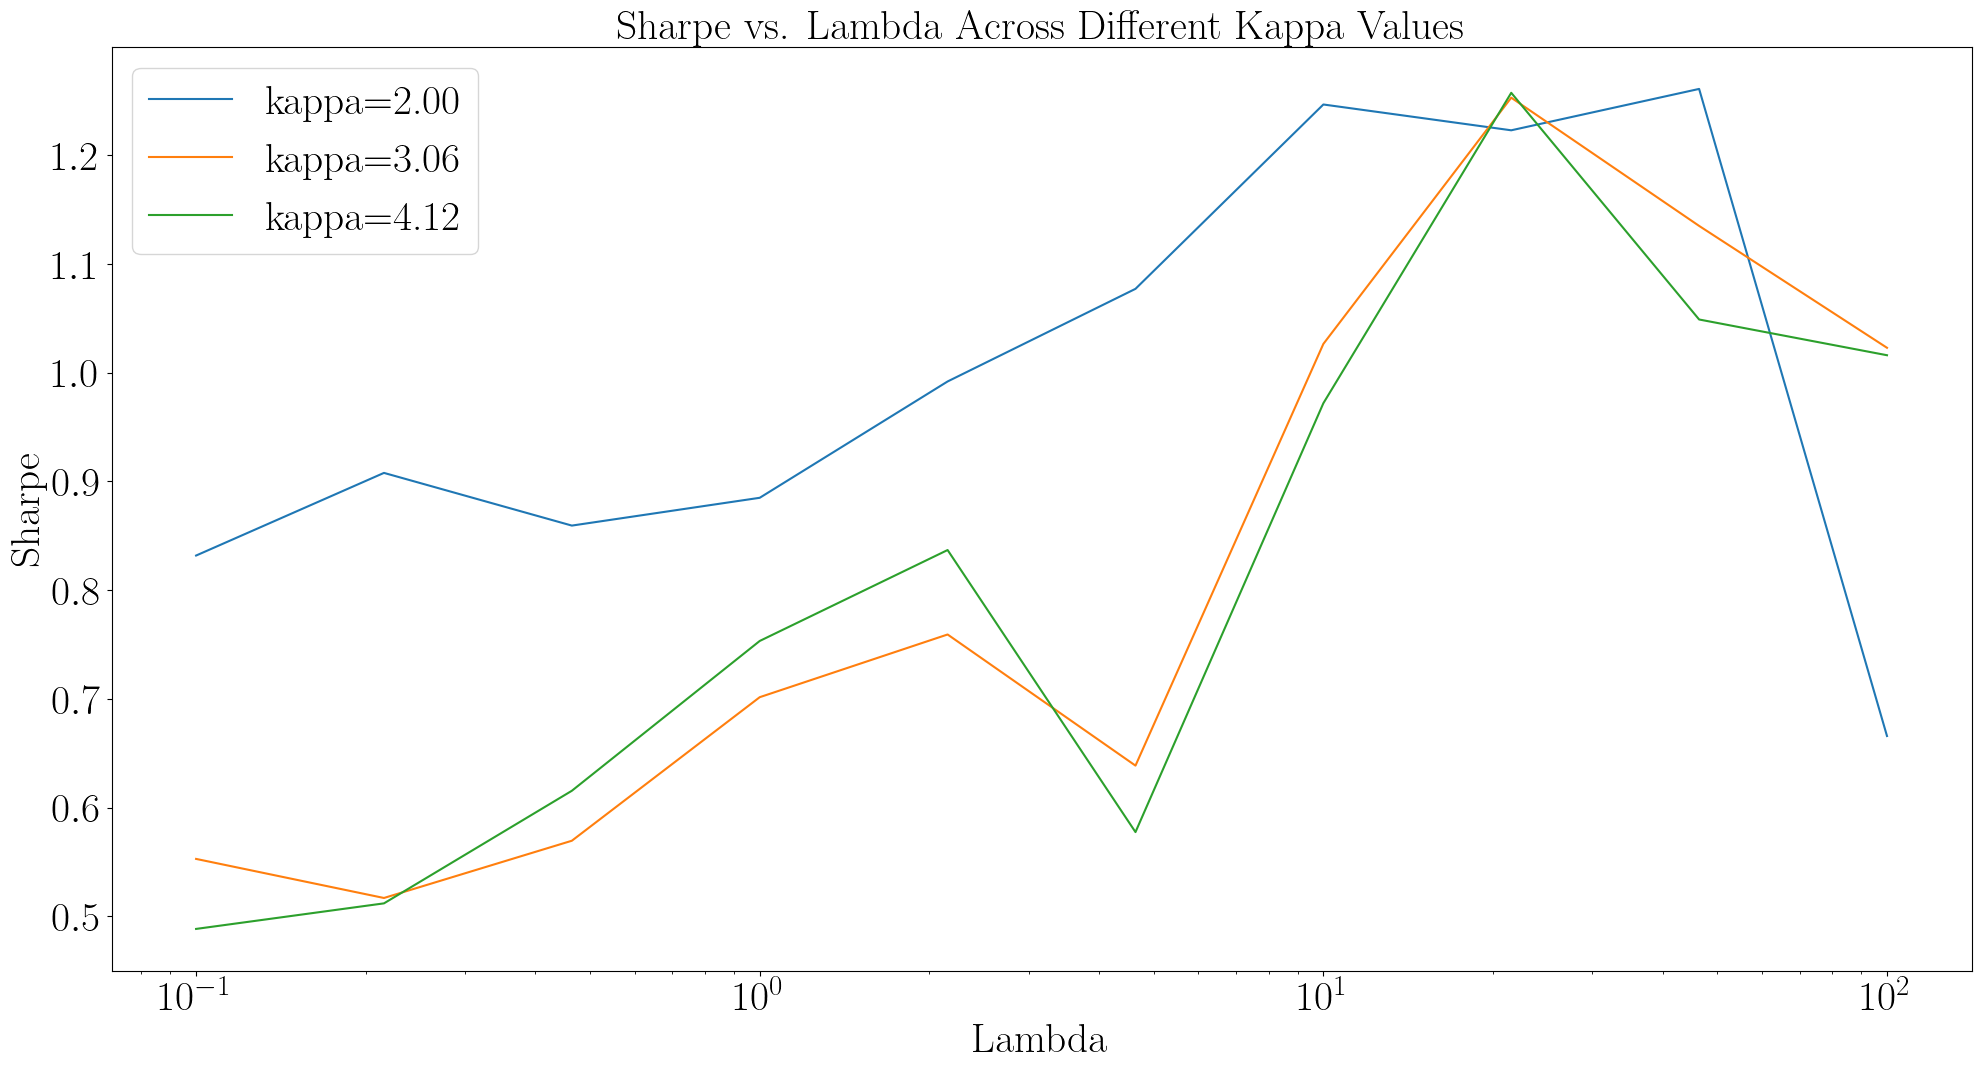

In [29]:
# Reshape so that rows correspond to each lambda and columns correspond to each kappa
results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))

plt.figure()
for i, kappa in enumerate(kappa_values):
    plt.plot(lambda_values, results_array[:, i], label=f"kappa={kappa:.2f}")

plt.xscale('log')  # Because lambda_values came from logspace
plt.xlabel('Lambda')
plt.ylabel('Sharpe')
plt.title('Sharpe vs. Lambda Across Different Kappa Values')
plt.legend()
plt.show()

In [30]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=max_feats_best, jump_penalty=best_lambda, cont=False, max_iter=30)
best_model.fit(X_train_processed, data.active_ret, sort_by="cumret")



SparseJumpModel(jump_penalty=46.41588833612777, max_feats=4)

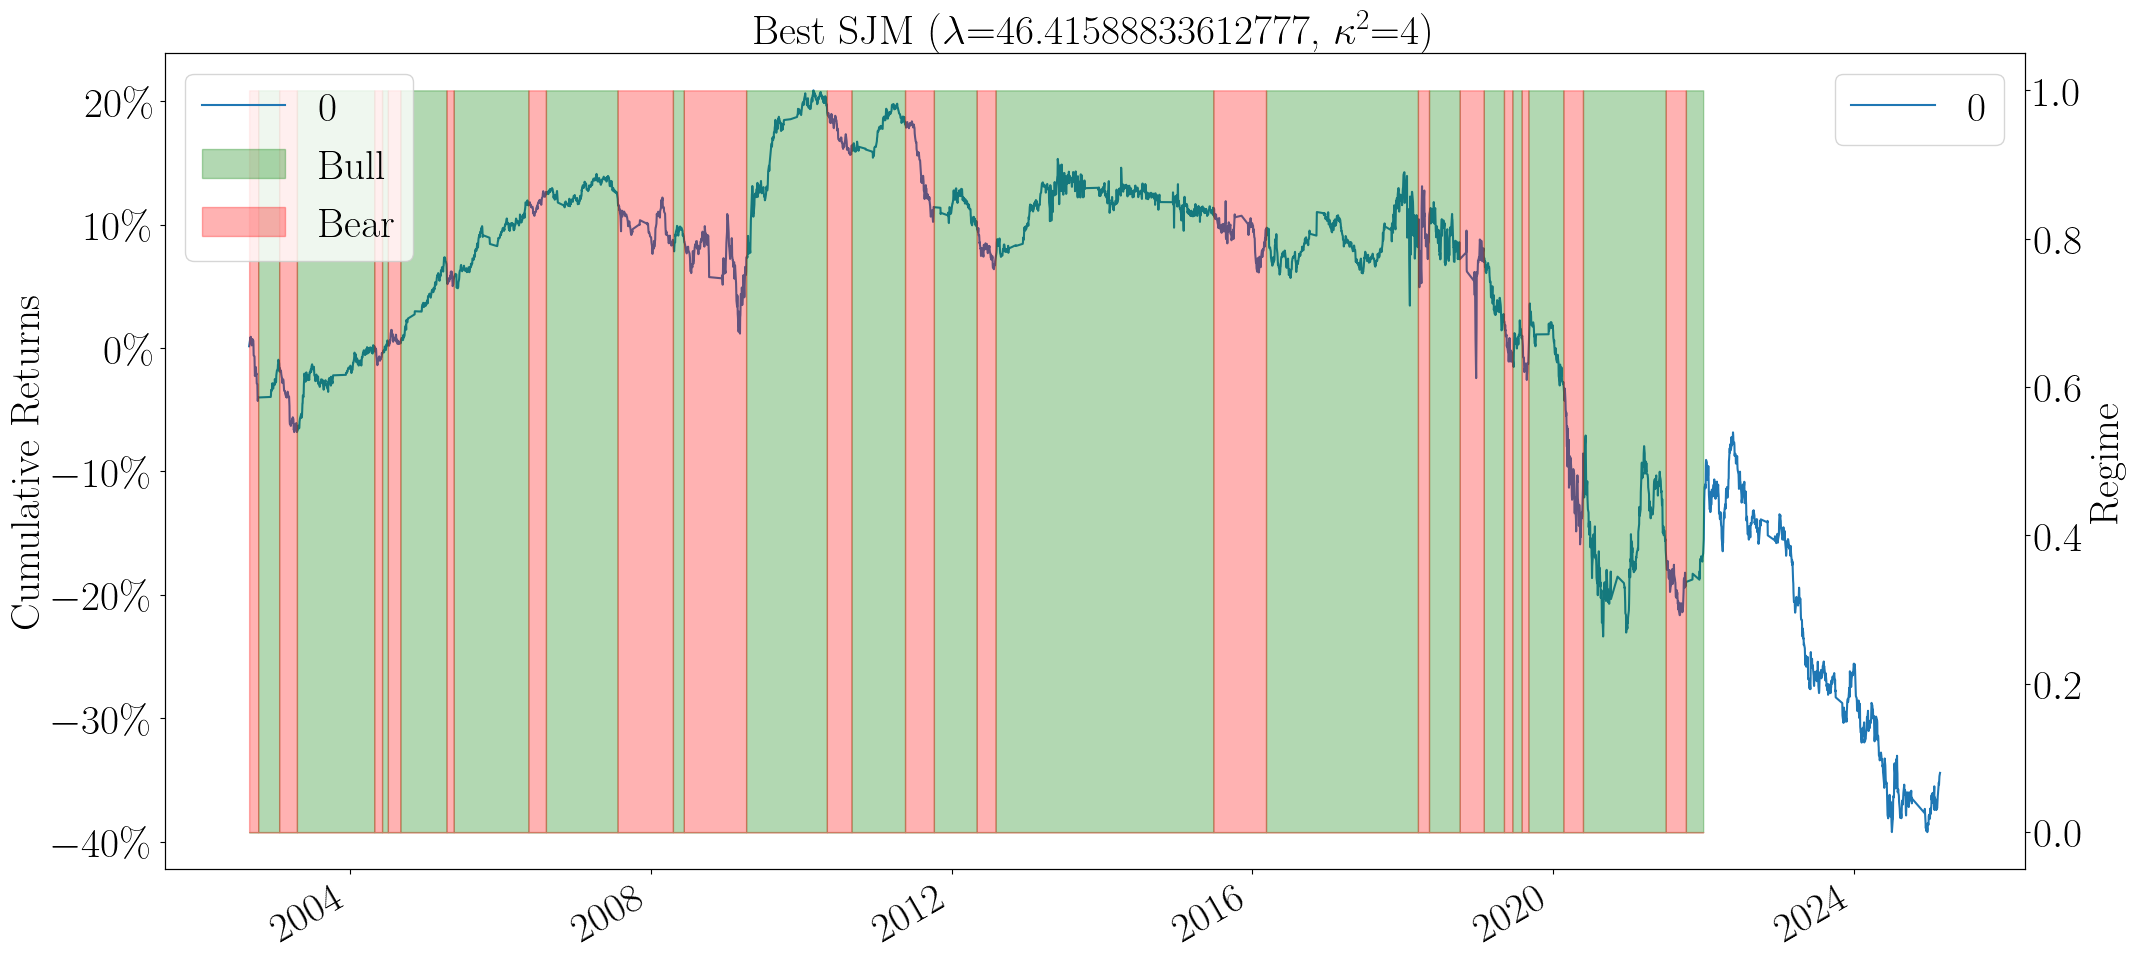

In [31]:
# **Predict and Plot Results**

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

predicted_states = best_model.predict(X_train_processed)

# print(predicted_states.head())
# print(factor_data["VLUE"].head())
# print(predicted_states.tail())
# print(factor_data["VLUE"].tail())

ax, ax2 = plot_regimes_and_cumret(predicted_states, data.active_ret)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
plt.show()

In [25]:
# Predict the states on the in-sample data
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(best_model.feat_weights)

Predicted states (in-sample):
Date
2002-08-28    1
2002-08-29    1
2002-08-30    1
2002-09-03    1
2002-09-04    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 3988, dtype: int64
SJM Feature Weights:
ActiveReturn_EWMA_8         0.341755
ActiveReturn_EWMA_21        0.429943
ActiveReturn_EWMA_63        0.401291
RSI_8                       0.369822
RSI_21                      0.569048
RSI_63                      0.641048
StochOsc_%K_8               0.268367
StochOsc_%K_21              0.499869
StochOsc_%K_63              0.753722
MACD_8_21                   0.527609
MACD_21_63                  0.258377
DownsideDev_log_21          0.248556
ActiveMarketBeta_EWMA_21    0.042438
MarketReturn_EWMA_21        0.570570
VIX_log_diff_EWMA_21        0.443805
2Y_diff_EWMA_21             0.336269
10Y-2Y_EWMA_21              0.107720
dtype: float64


In [26]:
# # check constraints

# w = best_model.feat_weights ** 2
# l1 = w.sum()
# l2 = np.sqrt((w**2).sum())

# print("L1 norm =", l1)
# print("L2 norm =", l2)
# print("Expected L1 (≈ kappa):", np.sqrt(best_model.max_feats))

w_internals = best_model.w  # The internal lasso vector

l1_w = w_internals.sum()
l2_w = np.sqrt((w_internals**2).sum())

print("L1 norm of w_internals =", l1_w)
print("L2 norm of w_internals =", l2_w)
print("Expected L1 (≈ kappa) =", np.sqrt(best_model.max_feats))

L1 norm of w_internals = 3.2800984204732377
L2 norm of w_internals = 1.0
Expected L1 (≈ kappa) = 4.123105625617661


In [18]:
# print("\n\n".join(In[i] for i in range(1, len(In))))
# check constraints


In [19]:
# cd C:\Users\victo\0_thesis_repo\thesis_vri_vp\victor
# py -m jupyter nbconvert --to script sjm.ipynb